In [ ]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# 4. Feature Engineering - Numerical

## 4.3. Gauss Rank

In [1]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('../data/train.parquet')
df_valid = cudf.read_parquet('../data/valid.parquet')
df_test = cudf.read_parquet('../data/test.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_test['brand'] = df_test['brand'].fillna('UNKNOWN')

df_train['cat_0'] = df_train['cat_0'].fillna('UNKNOWN')
df_valid['cat_0'] = df_valid['cat_0'].fillna('UNKNOWN')
df_test['cat_0'] = df_test['cat_0'].fillna('UNKNOWN')

df_train['cat_1'] = df_train['cat_1'].fillna('UNKNOWN')
df_valid['cat_1'] = df_valid['cat_1'].fillna('UNKNOWN')
df_test['cat_1'] = df_test['cat_1'].fillna('UNKNOWN')

df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')
df_test['cat_2'] = df_test['cat_2'].fillna('UNKNOWN')

We generate some numerical features with the feature engineering from the previous notebooks.

In [2]:
def target_encode(train, valid, col, target, kfold=5, smooth=20, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [3]:
cats = [['cat_0'], ['cat_1'], ['cat_2'], ['cat_0', 'cat_1', 'cat_2'], ['ts_hour'], ['ts_weekday'], ['ts_weekday', 'ts_hour', 'cat_2', 'brand']]

In [4]:
for cat in cats:
    df_train, df_valid = target_encode(df_train, df_valid, cat, 'target')

In [5]:
cats = ['brand', 'user_id', 'product_id', 'cat_0', 'cat_1', 'cat_2']

In [6]:
def count_encode(train, valid, col, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:    column which will be count encoded (in the example RESOURCE)
    """
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    
    train_tmp = train[col].value_counts().reset_index()
    train_tmp.columns = [col,  'CE_' + col]
    df_tmp = train[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    train['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
        
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp = valid[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [7]:
%%time

for cat in cats:
    df_train, df_valid = count_encode(df_train, df_valid, cat, gpu=True)

CPU times: user 644 ms, sys: 1.27 s, total: 1.92 s
Wall time: 1.92 s


In [8]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,...,TE_cat_0_cat_1_cat_2,TE_ts_hour,TE_ts_weekday,TE_ts_weekday_ts_hour_cat_2_brand,CE_brand,CE_user_id,CE_product_id,CE_cat_0,CE_cat_1,CE_cat_2
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,...,0.280155,0.305423,0.410060,0.301241,10859,9,743,372964,51652,5058060
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.350069,0.305249,0.410061,0.333539,50273,56,12,1527338,287043,213674
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.351989,0.305235,0.410059,0.319065,50273,56,12,1527338,287043,213674
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.351410,0.305370,0.410061,0.333539,50273,56,12,1527338,287043,213674
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,...,0.460389,0.305449,0.410061,0.466269,2323417,9,317711,3363367,3307872,3172781


## Theory

In the previous notebook, we discussed how important *Normalization* is for neural networks. We learned some basic strategies for normalizing numerical features. In this notebook, we will provide another normalization technique, called <b>*Gauss Rank*</b>.<br><br>

<b>*Gauss Rank*</b> transforms any arbitrary distribution to a Gaussian normal distribution by
1. Compute the rank (or sort the values ascending)
2. Scale the values linearly from -1 to +1
3. Apply the erfinv function

<img src='../images/gaussrank.png' width=50%>

Source: https://medium.com/rapids-ai/gauss-rank-transformation-is-100x-faster-with-rapids-and-cupy-7c947e3397da

In [9]:
import cupy as cp
from cupyx.scipy.special import erfinv
import cudf as gd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfinv as sp_erfinv

In [10]:
def gaussrank_cpu(data, epsilon = 1e-6):
    r_cpu = data.argsort().argsort()
    r_cpu = (r_cpu/r_cpu.max()-0.5)*2 # scale to (-1,1)
    r_cpu = np.clip(r_cpu,-1+epsilon,1-epsilon)
    r_cpu = sp_erfinv(r_cpu)
    return(r_cpu)

def gaussrank_gpu(data, epsilon = 1e-6):
    r_gpu = data.argsort().argsort()
    r_gpu = (r_gpu/r_gpu.max()-0.5)*2 # scale to (-1,1)
    r_gpu = cp.clip(r_gpu,-1+epsilon,1-epsilon)
    r_gpu = erfinv(r_gpu)
    return(r_gpu)

Text(0.5, 1.0, 'Histogram Gauss Rank')

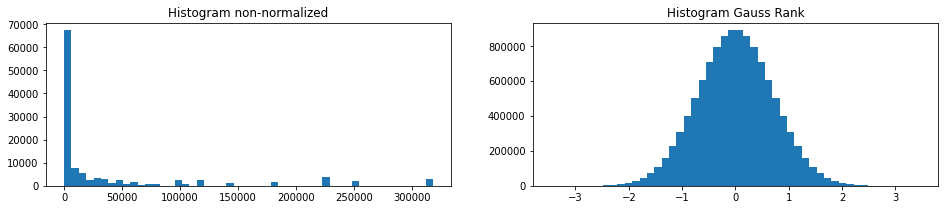

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
col = 'CE_product_id'
data_sample = df_train[col].sample(frac=0.01)
axs[0].hist(data_sample.to_pandas().values, bins=50)
axs[1].hist(cp.asnumpy(gaussrank_gpu(df_train[col].values)), bins=50)
axs[0].set_title('Histogram non-normalized')
axs[1].set_title('Histogram Gauss Rank')

## Practice

Now, it is your turn.<br><br>

**ToDo**:
<li>Normalize the features price, TE_ts_weekday_ts_hour_cat_2_brand and CE_cat_2 with GaussRank<br>
<li>Plot the non-normalized and normalized values

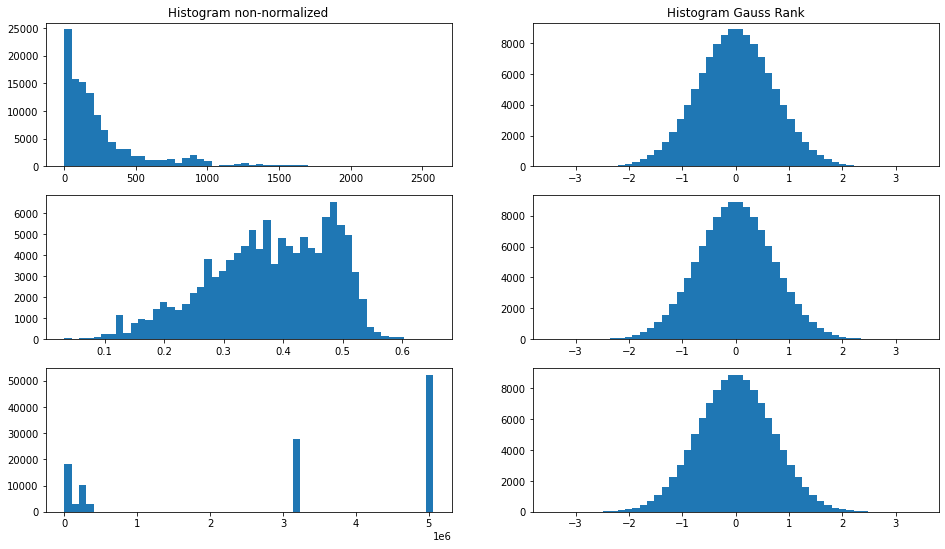

In [12]:
############### Solution ###############

fig, axs = plt.subplots(3, 2, figsize=(16,9))
for i, col in enumerate(['price', 'TE_ts_weekday_ts_hour_cat_2_brand', 'CE_cat_2']):
    data_sample = df_train[col].sample(frac=0.01)
    axs[i, 0].hist(data_sample.to_pandas(), bins=50)
    axs[i, 1].hist(cp.asnumpy(gaussrank_gpu(data_sample.values)), bins=50)
    if i==0:
        axs[i, 0].set_title('Histogram non-normalized')
        axs[i, 1].set_title('Histogram Gauss Rank')

In [13]:
############### Solution End ###########

## Optimization

Let's compare a CPU with the GPU version.

In [14]:
data_cpu = df_train['TE_ts_weekday_ts_hour_cat_2_brand'].to_pandas().values
data_gpu = df_train['TE_ts_weekday_ts_hour_cat_2_brand'].values

In [15]:
%%time 

gaussrank_cpu(data_cpu)

CPU times: user 3.76 s, sys: 176 ms, total: 3.94 s
Wall time: 3.93 s


array([-0.49958087, -0.31557098, -0.39975219, ..., -0.33439334,
        0.06216684, -0.5348664 ])

In [16]:
%%time 

gaussrank_gpu(data_gpu)

CPU times: user 36 ms, sys: 64 ms, total: 100 ms
Wall time: 100 ms


array([-0.50025555, -0.31601779, -0.40005142, ..., -0.3343783 ,
        0.06505958, -0.53484046])

In our experiments, we achieved a speedup of 80.3x.

We shutdown the kernel.

In [17]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}